In [1]:
# !pip install datasets sentencepiece transformers

In [2]:
# from datasets import load_dataset
# from google.colab import drive
# from IPython.display import display
# from IPython.html import widgets
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# import torch
# from torch import optim
# from torch.nn import functional as F
# from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
# from transformers import get_linear_schedule_with_warmup
# from tqdm import tqdm_notebook

# sns.set()

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print("Using device: %s" % (device))

In [3]:
from datasets import load_dataset
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: %s" % (device))

Using device: cuda


In [4]:
model_repo = 'google/mt5-base'

tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model.to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [5]:
dataset = load_dataset('alt')
train_dataset = dataset['train']
test_dataset = dataset['test']
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [6]:
LANG_TOKEN_MAPPING = {
    'vi': '<vi> ',
    'lo': '<lo> ',
}

# LANG_TOKEN_MAPPING = {
#     'vi': 'translate Lao to Vietnamese: ',
#     'lo': 'translate Vietnamese to Lao: ',
# }

max_seq_len = 144

In [7]:
sampleInputSentence = '<lo> Phiên dịch tiếng Lào: câu này sẽ được dịch thành tiếng Lào.'
sampleOutputSentence = 'ແປເປັນພາສາລາວ.'

tokenizerOutput = tokenizer(
    text = sampleInputSentence,
    text_target = sampleOutputSentence,
    return_tensors = 'pt',
    padding = 'max_length',
    truncation = True,
    max_length = max_seq_len).to(device)
print(tokenizerOutput['input_ids'])
print(tokenizer.convert_ids_to_tokens(tokenizerOutput['input_ids'][0]))
print(tokenizer.decode(tokenizerOutput['input_ids'][0]))

model.eval()
modelOutput = model(tokenizerOutput['input_ids'],
                    attention_mask = tokenizerOutput['attention_mask'],
                    labels = tokenizerOutput['labels'])

modelGenerate = model.generate(tokenizerOutput['input_ids'], max_new_tokens = max_seq_len)
print(modelGenerate)

output_text = tokenizer.decode(modelGenerate[0])
print(tokenizer.convert_ids_to_tokens(modelGenerate[0]))
print(output_text)

tensor([[ 1042,   878,   669,   363, 12093,   331,  3168,  2868,   370,   458,
          5395,   267,  4650,   273,  2424,   259,   263,  2254,   259,  1318,
           331,  3168,   394,  3255,  2868,   370,   458,  5395,   260,     1,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [8]:
# sorted(tokenizer.vocab.items(), key=lambda x: x[1])

In [9]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 768)

In [10]:
tokenizerOutput = tokenizer(
    text = sampleInputSentence,
    text_target = sampleOutputSentence,
    return_tensors = 'pt',
    padding = 'max_length',
    truncation = True,
    max_length = max_seq_len).to(device)

tokens = tokenizer.convert_ids_to_tokens(tokenizerOutput['input_ids'][0])
print(tokens) # Make sure that the special translation token is not 'fragmented'

['<lo> ', '▁P', 'hiên', '▁d', 'ịch', '▁tiế', 'ng', '▁L', 'ào', ':', '▁câ', 'u', '▁này', '▁', 's', 'ẽ', '▁', 'được', '▁d', 'ịch', '▁th', 'ành', '▁tiế', 'ng', '▁L', 'ào', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [11]:
def encode_str(text, text_target, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):

    target_lang_token = lang_token_map[target_lang]

    # Tokenize and add special tokens
    tokenizerOutp = tokenizer(
        text = target_lang_token + text,
        text_target = text_target,
        return_tensors = 'pt',
        padding = 'max_length',
        truncation = True,
        max_length = seq_len)

    return tokenizerOutp['input_ids'][0], tokenizerOutp['labels'][0], tokenizerOutp['attention_mask'][0]


def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=max_seq_len):

    # Choose a random 2 languages for in i/o
    langs = list(lang_token_map.keys())
    input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

    # Get the translations for the batch
    input_text = translations[input_lang]
    target_text = translations[target_lang]

    if input_text is None or target_text is None:
        return None

    input_token_ids, target_token_ids, attention_mask = encode_str(
        input_text, target_text, target_lang, tokenizer, seq_len, lang_token_map)

    return input_token_ids, target_token_ids, attention_mask

def transform_batch(batch, lang_token_map, tokenizer):
    inputs = []
    targets = []
    attentionMask = []
    for translation_set in batch['translation']:
        formatted_data = format_translation_data(
            translation_set, lang_token_map, tokenizer, max_seq_len)

        if formatted_data is None:
            continue

        input_ids, target_ids, attention_mask = formatted_data

        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))
        attentionMask.append(attention_mask.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()
    attentionMask = torch.cat(attentionMask).cuda()

    return batch_input_ids, batch_target_ids, attentionMask

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size = 32):
    dataset = dataset.shuffle()
    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [12]:
# Testing `data_transform`
in_ids, out_ids, attention_mask = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)
print('Attention mask shape:', data_batch[2].shape)

<lo>  ▁ Ý ▁đ ã ▁đ ánh ▁b ại ▁B ồ ▁Đ ào ▁Nh a ▁v ới ▁ t ỉ ▁ s ố ▁3 1-5 ▁ ở ▁B ảng ▁C ▁Gi ải ▁v ô ▁đ ịch ▁ Rugby ▁th ế ▁gi ới ▁2007 ▁ t ại ▁Parc ▁des ▁Princes , ▁Pari , ▁P háp . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ ອິ ຕາ ລີ ໄດ້ ເສຍ ໃຫ້ ປ ໊ ອກ ຕຸ ຍ ການ ▁31 ▁ຕໍ່ ▁5 ▁ໃນ ພູ ລ ▁C ▁ຂອງ ▁ການ ແຂ່ງຂັນ ຣັ ກ ບ ີ້ ລະດັບ ໂລກ ປີ ▁2007 ▁ທີ່ ▁ ປາກ ເດ ແພ ຣັ ງ ▁ ປາ ຣີ ▁ ປະເທດ ຝ ຣ ັ່ງ . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [13]:
# Constants
n_epochs = 25
batch_size = 32
print_freq = 50
checkpoint_freq = 500
lr = 7.5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [14]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
losses = []
valLosses = []

In [16]:
def eval_model(model, gdataset, max_iters=8):
    
    model.eval()
    test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
    eval_losses = []
    for i, (input_batch, label_batch, attention_mask_batch) in enumerate(test_generator):
        if i >= max_iters:
            break
    
        model_out = model(
            input_ids = input_batch,
            labels = label_batch,
            attention_mask = attention_mask_batch)
        eval_losses.append(model_out.loss.item())
    
    return np.mean(eval_losses)

In [17]:
model_path = 'mT5FineTunedEpoch{}.pt'

In [18]:
for epoch_idx in range(n_epochs):
    # Randomize data order
    data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
    
    for batch_idx, (input_batch, label_batch, attention_mask_batch) \
            in tqdm_notebook(enumerate(data_generator), total=n_batches):
        
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        model_out = model(
            input_ids = input_batch,
            labels = label_batch,
            attention_mask = attention_mask_batch)
        
        # Calculate loss and update weights
        loss = model_out.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Print training update info
        if (batch_idx + 1) % print_freq == 0:
          avg_loss = np.mean(losses[-print_freq:])
          print('Epoch: {} | Step: {}/{} | Avg. loss: {:.3f} | lr: {}'.format(
              epoch_idx+1, batch_idx+1, n_batches, avg_loss, scheduler.get_last_lr()[0]))
        
        if (batch_idx + 1) % checkpoint_freq == 0:
          test_loss = eval_model(model, test_dataset)
          valLosses.append(test_loss)
          print('Saving model with test loss of {:.3f}'.format(test_loss))
          # torch.save(model.state_dict(), model_path.format(epoch_idx + 1))

torch.save(model.state_dict(), model_path.format(epoch_idx + 1))

/tmp/ipykernel_8838/3895180792.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 1 | Step: 50/566 | Avg. loss: 19.578 | lr: 0.00026595744680851064
Epoch: 1 | Step: 100/566 | Avg. loss: 3.492 | lr: 0.0005319148936170213
Epoch: 1 | Step: 150/566 | Avg. loss: 2.502 | lr: 0.0007495181668927118
Epoch: 1 | Step: 200/566 | Avg. loss: 2.202 | lr: 0.0007468413162966664
Epoch: 1 | Step: 250/566 | Avg. loss: 2.068 | lr: 0.000744164465700621
Epoch: 1 | Step: 300/566 | Avg. loss: 1.974 | lr: 0.0007414876151045757
Epoch: 1 | Step: 350/566 | Avg. loss: 1.918 | lr: 0.0007388107645085302
Epoch: 1 | Step: 400/566 | Avg. loss: 1.795 | lr: 0.0007361339139124849
Epoch: 1 | Step: 450/566 | Avg. loss: 1.745 | lr: 0.0007334570633164394
Epoch: 1 | Step: 500/566 | Avg. loss: 1.700 | lr: 0.000730780212720394
Saving model with test loss of 1.709
Epoch: 1 | Step: 550/566 | Avg. loss: 1.646 | lr: 0.0007281033621243486


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 2 | Step: 50/566 | Avg. loss: 1.573 | lr: 0.0007245699193375687
Epoch: 2 | Step: 100/566 | Avg. loss: 1.511 | lr: 0.0007218930687415234
Epoch: 2 | Step: 150/566 | Avg. loss: 1.464 | lr: 0.0007192162181454779
Epoch: 2 | Step: 200/566 | Avg. loss: 1.434 | lr: 0.0007165393675494326
Epoch: 2 | Step: 250/566 | Avg. loss: 1.407 | lr: 0.0007138625169533871
Epoch: 2 | Step: 300/566 | Avg. loss: 1.365 | lr: 0.0007111856663573417
Epoch: 2 | Step: 350/566 | Avg. loss: 1.326 | lr: 0.0007085088157612963
Epoch: 2 | Step: 400/566 | Avg. loss: 1.326 | lr: 0.000705831965165251
Epoch: 2 | Step: 450/566 | Avg. loss: 1.318 | lr: 0.0007031551145692055
Epoch: 2 | Step: 500/566 | Avg. loss: 1.294 | lr: 0.0007004782639731601
Saving model with test loss of 1.282
Epoch: 2 | Step: 550/566 | Avg. loss: 1.266 | lr: 0.0006978014133771147


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 3 | Step: 50/566 | Avg. loss: 1.234 | lr: 0.0006942679705903348
Epoch: 3 | Step: 100/566 | Avg. loss: 1.233 | lr: 0.0006915911199942893
Epoch: 3 | Step: 150/566 | Avg. loss: 1.225 | lr: 0.000688914269398244
Epoch: 3 | Step: 200/566 | Avg. loss: 1.206 | lr: 0.0006862374188021986
Epoch: 3 | Step: 250/566 | Avg. loss: 1.189 | lr: 0.0006835605682061532
Epoch: 3 | Step: 300/566 | Avg. loss: 1.166 | lr: 0.0006808837176101078
Epoch: 3 | Step: 350/566 | Avg. loss: 1.179 | lr: 0.0006782068670140624
Epoch: 3 | Step: 400/566 | Avg. loss: 1.166 | lr: 0.000675530016418017
Epoch: 3 | Step: 450/566 | Avg. loss: 1.200 | lr: 0.0006728531658219716
Epoch: 3 | Step: 500/566 | Avg. loss: 1.160 | lr: 0.0006701763152259263
Saving model with test loss of 1.192
Epoch: 3 | Step: 550/566 | Avg. loss: 1.176 | lr: 0.0006674994646298808


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 4 | Step: 50/566 | Avg. loss: 1.125 | lr: 0.0006639660218431009
Epoch: 4 | Step: 100/566 | Avg. loss: 1.126 | lr: 0.0006612891712470555
Epoch: 4 | Step: 150/566 | Avg. loss: 1.113 | lr: 0.0006586123206510101
Epoch: 4 | Step: 200/566 | Avg. loss: 1.125 | lr: 0.0006559354700549646
Epoch: 4 | Step: 250/566 | Avg. loss: 1.101 | lr: 0.0006532586194589193
Epoch: 4 | Step: 300/566 | Avg. loss: 1.099 | lr: 0.0006505817688628739
Epoch: 4 | Step: 350/566 | Avg. loss: 1.110 | lr: 0.0006479049182668285
Epoch: 4 | Step: 400/566 | Avg. loss: 1.113 | lr: 0.000645228067670783
Epoch: 4 | Step: 450/566 | Avg. loss: 1.105 | lr: 0.0006425512170747376
Epoch: 4 | Step: 500/566 | Avg. loss: 1.125 | lr: 0.0006398743664786924
Saving model with test loss of 1.156
Epoch: 4 | Step: 550/566 | Avg. loss: 1.093 | lr: 0.0006371975158826469


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 5 | Step: 50/566 | Avg. loss: 1.056 | lr: 0.000633664073095867
Epoch: 5 | Step: 100/566 | Avg. loss: 1.066 | lr: 0.0006309872224998216
Epoch: 5 | Step: 150/566 | Avg. loss: 1.059 | lr: 0.0006283103719037762
Epoch: 5 | Step: 200/566 | Avg. loss: 1.051 | lr: 0.0006256335213077307
Epoch: 5 | Step: 250/566 | Avg. loss: 1.062 | lr: 0.0006229566707116853
Epoch: 5 | Step: 300/566 | Avg. loss: 1.045 | lr: 0.00062027982011564
Epoch: 5 | Step: 350/566 | Avg. loss: 1.065 | lr: 0.0006176029695195946
Epoch: 5 | Step: 400/566 | Avg. loss: 1.053 | lr: 0.0006149261189235491
Epoch: 5 | Step: 450/566 | Avg. loss: 1.036 | lr: 0.0006122492683275038
Epoch: 5 | Step: 500/566 | Avg. loss: 1.070 | lr: 0.0006095724177314583
Saving model with test loss of 1.156
Epoch: 5 | Step: 550/566 | Avg. loss: 1.047 | lr: 0.0006068955671354129


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 6 | Step: 50/566 | Avg. loss: 1.012 | lr: 0.000603362124348633
Epoch: 6 | Step: 100/566 | Avg. loss: 1.004 | lr: 0.0006006852737525877
Epoch: 6 | Step: 150/566 | Avg. loss: 1.015 | lr: 0.0005980084231565423
Epoch: 6 | Step: 200/566 | Avg. loss: 1.007 | lr: 0.0005953315725604968
Epoch: 6 | Step: 250/566 | Avg. loss: 1.000 | lr: 0.0005926547219644515
Epoch: 6 | Step: 300/566 | Avg. loss: 0.995 | lr: 0.000589977871368406
Epoch: 6 | Step: 350/566 | Avg. loss: 1.012 | lr: 0.0005873010207723606
Epoch: 6 | Step: 400/566 | Avg. loss: 0.997 | lr: 0.0005846241701763153
Epoch: 6 | Step: 450/566 | Avg. loss: 0.991 | lr: 0.0005819473195802699
Epoch: 6 | Step: 500/566 | Avg. loss: 0.983 | lr: 0.0005792704689842244
Saving model with test loss of 1.134
Epoch: 6 | Step: 550/566 | Avg. loss: 1.005 | lr: 0.000576593618388179


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 7 | Step: 50/566 | Avg. loss: 0.933 | lr: 0.0005730601756013991
Epoch: 7 | Step: 100/566 | Avg. loss: 0.943 | lr: 0.0005703833250053537
Epoch: 7 | Step: 150/566 | Avg. loss: 0.936 | lr: 0.0005677064744093082
Epoch: 7 | Step: 200/566 | Avg. loss: 0.928 | lr: 0.000565029623813263
Epoch: 7 | Step: 250/566 | Avg. loss: 0.939 | lr: 0.0005623527732172175
Epoch: 7 | Step: 300/566 | Avg. loss: 0.925 | lr: 0.0005596759226211721
Epoch: 7 | Step: 350/566 | Avg. loss: 0.914 | lr: 0.0005569990720251267
Epoch: 7 | Step: 400/566 | Avg. loss: 0.948 | lr: 0.0005543222214290813
Epoch: 7 | Step: 450/566 | Avg. loss: 0.946 | lr: 0.000551645370833036
Epoch: 7 | Step: 500/566 | Avg. loss: 0.981 | lr: 0.0005489685202369905
Saving model with test loss of 1.127
Epoch: 7 | Step: 550/566 | Avg. loss: 1.206 | lr: 0.0005462916696409452


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 8 | Step: 50/566 | Avg. loss: 0.899 | lr: 0.0005427582268541652
Epoch: 8 | Step: 100/566 | Avg. loss: 0.874 | lr: 0.0005400813762581198
Epoch: 8 | Step: 150/566 | Avg. loss: 0.847 | lr: 0.0005374045256620744
Epoch: 8 | Step: 200/566 | Avg. loss: 0.810 | lr: 0.000534727675066029
Epoch: 8 | Step: 250/566 | Avg. loss: 0.785 | lr: 0.0005320508244699836
Epoch: 8 | Step: 300/566 | Avg. loss: 0.770 | lr: 0.0005293739738739382
Epoch: 8 | Step: 350/566 | Avg. loss: 0.769 | lr: 0.0005266971232778928
Epoch: 8 | Step: 400/566 | Avg. loss: 0.751 | lr: 0.0005240202726818474
Epoch: 8 | Step: 450/566 | Avg. loss: 0.750 | lr: 0.0005213434220858019
Epoch: 8 | Step: 500/566 | Avg. loss: 0.739 | lr: 0.0005186665714897567
Saving model with test loss of 0.882
Epoch: 8 | Step: 550/566 | Avg. loss: 0.757 | lr: 0.0005159897208937112


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 9 | Step: 50/566 | Avg. loss: 0.675 | lr: 0.0005124562781069313
Epoch: 9 | Step: 100/566 | Avg. loss: 0.692 | lr: 0.0005097794275108859
Epoch: 9 | Step: 150/566 | Avg. loss: 0.679 | lr: 0.0005071025769148405
Epoch: 9 | Step: 200/566 | Avg. loss: 0.685 | lr: 0.0005044257263187951
Epoch: 9 | Step: 250/566 | Avg. loss: 0.683 | lr: 0.0005017488757227496
Epoch: 9 | Step: 300/566 | Avg. loss: 0.670 | lr: 0.0004990720251267042
Epoch: 9 | Step: 350/566 | Avg. loss: 0.665 | lr: 0.0004963951745306589
Epoch: 9 | Step: 400/566 | Avg. loss: 0.662 | lr: 0.0004937183239346135
Epoch: 9 | Step: 450/566 | Avg. loss: 0.652 | lr: 0.000491041473338568
Epoch: 9 | Step: 500/566 | Avg. loss: 0.656 | lr: 0.0004883646227425227
Saving model with test loss of 0.796
Epoch: 9 | Step: 550/566 | Avg. loss: 0.663 | lr: 0.00048568777214647724


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 10 | Step: 50/566 | Avg. loss: 0.592 | lr: 0.0004821543293596974
Epoch: 10 | Step: 100/566 | Avg. loss: 0.593 | lr: 0.0004794774787636519
Epoch: 10 | Step: 150/566 | Avg. loss: 0.582 | lr: 0.00047680062816760657
Epoch: 10 | Step: 200/566 | Avg. loss: 0.602 | lr: 0.00047412377757156114
Epoch: 10 | Step: 250/566 | Avg. loss: 0.582 | lr: 0.00047144692697551576
Epoch: 10 | Step: 300/566 | Avg. loss: 0.594 | lr: 0.0004687700763794704
Epoch: 10 | Step: 350/566 | Avg. loss: 0.608 | lr: 0.00046609322578342494
Epoch: 10 | Step: 400/566 | Avg. loss: 0.593 | lr: 0.00046341637518737956
Epoch: 10 | Step: 450/566 | Avg. loss: 0.601 | lr: 0.0004607395245913341
Epoch: 10 | Step: 500/566 | Avg. loss: 0.592 | lr: 0.0004580626739952888
Saving model with test loss of 0.780
Epoch: 10 | Step: 550/566 | Avg. loss: 0.593 | lr: 0.0004553858233992433


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 11 | Step: 50/566 | Avg. loss: 0.518 | lr: 0.00045185238061246346
Epoch: 11 | Step: 100/566 | Avg. loss: 0.523 | lr: 0.000449175530016418
Epoch: 11 | Step: 150/566 | Avg. loss: 0.526 | lr: 0.00044649867942037264
Epoch: 11 | Step: 200/566 | Avg. loss: 0.526 | lr: 0.0004438218288243272
Epoch: 11 | Step: 250/566 | Avg. loss: 0.531 | lr: 0.00044114497822828183
Epoch: 11 | Step: 300/566 | Avg. loss: 0.537 | lr: 0.0004384681276322364
Epoch: 11 | Step: 350/566 | Avg. loss: 0.541 | lr: 0.000435791277036191
Epoch: 11 | Step: 400/566 | Avg. loss: 0.548 | lr: 0.0004331144264401456
Epoch: 11 | Step: 450/566 | Avg. loss: 0.539 | lr: 0.00043043757584410025
Epoch: 11 | Step: 500/566 | Avg. loss: 0.551 | lr: 0.0004277607252480549
Saving model with test loss of 0.819


KeyboardInterrupt: 

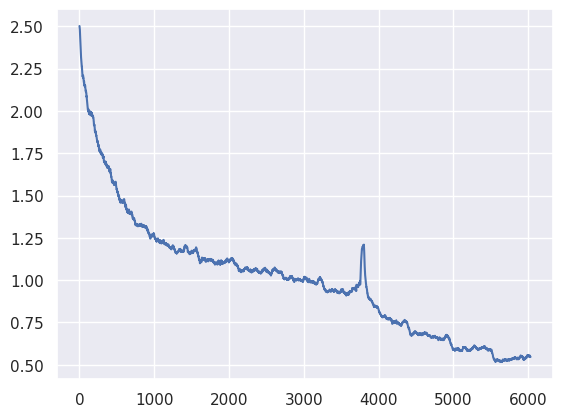

In [19]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

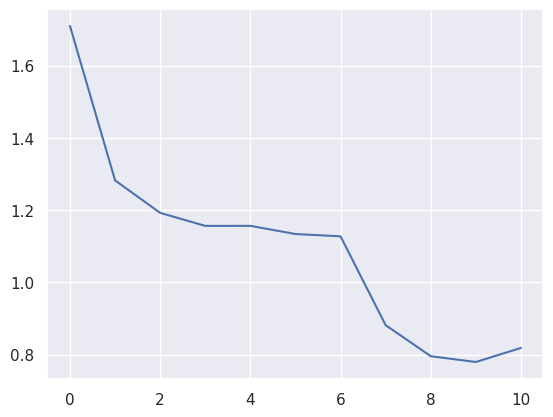

In [20]:
plt.plot(valLosses)

In [21]:
test_loss = eval_model(model, test_dataset)
test_loss

0.8017804175615311

In [22]:
test_dataset[0]['translation']

{'bg': 'সিডনির র\u200d্যান্ডউইক রেসের মাঠের আটটি থরোব্রেড রেসের ঘোড়া্র এক্যুইন ইনফ্লুয়েঞ্জাতে আক্রান্ত হওয়ার খবরটি নিশ্চিত করা হয়েছে।',
 'en': 'It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.',
 'en_tok': 'It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza .',
 'fil': 'Kumpirmado na walong magandang lahing pangkarerang kabayo sa Randwick Racecourse sa Sydney ang nagkaroon ng trangkaso.',
 'hi': 'यह पुष्टि की गई है कि सिडनी में रैंडविक रेसकोर्स के आठ घनी नस्ल के घोड़े इक्वाइन इन्फ्लूएंजा से संक्रमित हैं।',
 'id': 'Telah dikonfirmasi bahwa 8 kuda pacu thoroughbred di pacuan kuda Randwick di Sydney telah terinfeksi oleh flu kuda.',
 'ja': 'シドニーのランドウィック競馬場の8頭のサラブレッド競走馬が馬インフルエンザに感染していることが確認された。',
 'khm': 'គេបានបញ្ចាក់ថាសេះពូជប្រណាំងទាំង៨នៅទីលានប្រណាំងសេះរង់វីក \u200bទីក្រុងស៊ីដនីបានឆ្លងរោគផ្ដាសាយធំរបស់សត្វសេះ។',
 'lo': 'ມີການຢັ

In [23]:
test_sentence = test_dataset[0]['translation']['lo']
test_target = test_dataset[0]['translation']['vi']
print('Raw input text:', test_sentence)

input_ids, _, _ = encode_str(
    text = test_sentence,
    text_target = test_target,
    target_lang = 'vi',
    tokenizer = tokenizer,
    seq_len = max_seq_len,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: ມີການຢັ້ງຢືນແລ້ວວ່າ ມ້າແຂ່ງພັນແທ້ແປດໂຕ ທີ່ ແຣນວິກ ເລັສຄອສ ໃນ ຊິດນີ່ ໄດ້ຕິດເຊື້ອໄຂ້ຫວັດໃຫຍ່ມ້າ.
Truncated input text: <vi>  ມີການຢັ້ງຢືນແລ້ວວ່າ ມ້າແຂ່ງພັນແທ້ແປດໂຕ ທີ່ ແຣນວິກ ເລັສຄອສ ໃນ ຊິດນີ່ ໄດ້ຕິດເຊື້ອໄຂ້ຫວັດໃຫຍ່ມ້າ.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [26]:
output_tokens = model.generate(input_ids, num_beams=20, num_return_sequences=3, max_new_tokens = max_seq_len)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=False))

<pad> Hiện vẫn chưa được xác nhận rằng vận động viên trượt tuyết đã bị nhiễm cúm lợn gần như chưa được chẩn đoán của virus cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn.</s><pad><pad><pad>
<pad> Hiện vẫn chưa được xác nhận rằng vận động viên trượt tuyết đã bị nhiễm cúm lợn gần như chưa được chẩn đoán của virus cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như chưa được chẩn đoán.</s><pad>
<pad> Hiện vẫn chưa được xác nhận rằng vận động viên trượt tuyết đã bị nhiễm cúm lợn gần như chưa được chẩn đoán của virus cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như bệnh cúm lợn gần như
